In [1]:
import tensorflow as tf

# Training a convnet from scratch on a small dataset
Having to train an image-classification model using very little data is a common situation.

As a practical example, we’ll focus on classifying images as dogs or cats in a dataset containing $5,000$ pictures of cats and dogs ($2,500$ ```cats```, $2,500$ ```dogs```).
We’ll use:
- $2,000$ pictures for **training**;
- $1,000$ for **validation**;
- $2,000$ for **testing**.

## The relevance of deep learning for small-data problems
What qualifies as _“enough samples”_ to train a model is relative —relative to the size and depth of the model we’re trying to train.

It isn’t possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundred can potentially suffice if the model is small and well regularized and the task is simple. Because **convnets learn local translation-invariant features**, they’re highly data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will yield reasonable results despite a relative lack of data, without the need for any custom feature engineering.


## Downloading the data
The **Dogs vs. Cats dataset** that we will use isn’t packaged with Keras. It was made available by Kaggle as part of a computer vision competition in late 2013, back when convnets weren’t mainstream.

Download the original dataset [here](https://www.kaggle.com/c/dogs-vs-cats/data).

**N.B.**: it is also possible to use the Kaggle API to download the dataset in Colab.

### Downloading a Kaggle dataset in Google Colaboratory
Kaggle makes available an easy-to-use API to programmatically download Kaggle-hosted datasets. You can use it to download the Dogs vs. Cats dataset to a Colab notebook, for instance. This API is available as the kaggle package, which is preinstalled on Colab. Downloading this dataset is as easy as running the following command in a Colab cell:
```bash
!kaggle competitions download -c dogs-vs-cats
```
However, **access to the API is restricted to Kaggle users**, so in order to run the preceding command, you first need to authenticate yourself.

The kaggle package will look for your login credentials in a JSON file located at ```~/.kaggle/kaggle.json```. Let’s create this file:
- First, you need to create a Kaggle API key and download it to your local machine. Just navigate to the Kaggle website in a web browser, log in, and go to the My Account page. In your account settings, you’ll find an API section. Clicking the **Create New API Token** button will generate a _kaggle.json_ key file and will download it to your machine.

- Second, go to your Colab notebook, and upload the API’s key JSON file to your Colab session by running the following code in a notebook cell:
```bash
	from google.colab import files
	files.upload()
```

(When you run this cell, you will see a **Choose Files** button appear. Click it and select the _kaggle.json_ file you just downloaded. This uploads the file to the local Colab run-time.)

- Finally, create a _~/.kaggle folder_ (```mkdir ~/.kaggle```), and copy the key file to it (```cp kaggle.json ~/.kaggle/```). As a security best practice, you should also make sure that the file is only readable by the current user, yourself (```chmod 600```):
```bash
	!mkdir ~/.kaggle
	!cp kaggle.json ~/.kaggle/
	chmod 600 ~/.kaggle/kaggle.json
```

You can now download the data we’re about to use:
```bash
!kaggle competitions download -c dogs-vs-cats
```

The first time you try to download the data, you may get a _403 Forbidden_ error. That’s because you need to accept the terms associated with the dataset before you download it—you’ll have to go to [www.kaggle.com/c/dogs-vs-cats/rules](https://www.kaggle.com/c/dogs-vs-cats/rules) (while logged into your Kaggle account) and click the **I Understand and Accept** button. You only need to do this once.

Finally, the training data is a compressed file named _train.zip_. Make sure you uncompress it:
```bash
!unzip -qq train.zip
```

In [2]:
import os, shutil, pathlib
from constants import DATASETS_DIR_PATH, CATS_VS_DOGS_PATH

# Path to the directory where the original dataset was uncompressed
original_dir = pathlib.Path(CATS_VS_DOGS_PATH)

# Directory where we will store our smaller dataset
new_base_dir = pathlib.Path(os.path.join(DATASETS_DIR_PATH, "dogs_vs_cats_small"))

def make_subset(subset_name, start_index, end_index):
	"""
	Utility function to copy cat (and dog) images from index
	start_index to index end_index to the subdirectory
	new_base_dir/{subset_name}/cat (and /dog). The
	"subset_name" will be either "train", "validation", or "test".
	"""
	for category in ("cat", "dog"):
		dir = new_base_dir / subset_name / category
		os.makedirs(dir)
		fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
		for fname in fnames:
			shutil.copyfile(src=original_dir / fname,
							dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

The pictures in our dataset are medium-resolution color JPEGs.

<figure align="center">
	<img src="images\dogs-vs-cats-samples.png" width="50%">
	<figcaption>Samples from the Dogs vs. Cats dataset.</figcaption>
</figure>

The original dataset actually contains $25,000$ images (12,500 from each class), but we'll only use $5000$ to practice handling small datasets.

## Building the model

### Instantiating a small convnet for dogs vs. cats classification
We will start the model with a ```Rescaling``` layer, which will rescale image inputs (whose values are originally in the $[0, 255]$ range) to the $[0, 1]$ range.

The core of the convnet will be a stack of alternated ```Conv2D```(with ```relu``` activation) and ```MaxPooling2D``` layers.

Because we’re looking at a binary-classification problem, we’ll end the model with the ```Flatten``` layer and a single unit (a ```Dense``` layer of size 1) with a ```sigmoid``` activation. This unit will encode the probability that the model is looking at one class or the other.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [4]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

### Configuring the model for training
For the compilation step, we’ll go with the ```RMSprop``` optimizer.

Because we ended the model with a single sigmoid unit, we’ll use ```binary crossentropy``` as the loss.

In [5]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

## Data preprocessing
Currently, the data sits on a drive as JPEG files.

In order to feed them to the model we need to format the into appropriately preprocessed floating-point tensors.

The steps to do so are as follows:
1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Resize them to a shared size (we’ll use 180 × 180).
5. Pack them into batches (we’ll use batches of 32 images).

Keras comes with utilities to take care of these steps automatically. The function ```image_dataset_from_directory()``` lets us quickly set up a data pipeline that can turn image files on disk into batches of preprocessed tensors.

Calling ```image_dataset_from_directory(directory)``` will first list the subdirectories of the argument ```directory``` and assume each one contains images from one of our classes. It will then index the image files in each subdirectory. Finally, it will create and return a ```tf.data.Dataset``` object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Understanding TensorFlow _Dataset_ objects
TensorFlow makes available the ```tf.data``` API to create efficient input pipelines for machine learning models. Its core class is ```tf.data.Dataset```.

A _Dataset_ object is an iterator: you can use it in a for loop. It will typically return batches of input data and labels. You can pass a Dataset object directly to the ```fit()``` method of a Keras model. The Dataset class handles many key features that would otherwise be cumbersome to implement yourself -in particular, asynchronous data prefetching (preprocessing the next batch of data while the previous one is being handled by the model, which keeps execution flowing without interruptions) 

The _Dataset_ class also exposes a functional-style API for modifying datasets. Here’s a quick example: let’s create a Dataset instance from a NumPy array of random numbers. We’ll consider 1,000 samples, where each sample is a vector of size 16:

```python
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
```

At first, our dataset just yields single samples:

```python
>>> for i, element in enumerate(dataset):
>>> print(element.shape)
>>> if i >= 2:
>>> break
(16,)
(16,)
(16,)
```

We can use the ```.batch()``` method to batch the data:

```python
>>> batched_dataset = dataset.batch(32)
>>> for i, element in enumerate(batched_dataset):
>>> print(element.shape)
>>> if i >= 2:
>>> break
(32, 16)
(32, 16)
(32, 16)
```
More broadly, we have access to a range of useful dataset methods, such as
- ```.shuffle(buffer_size)```—Shuffles elements within a buffer;
- ```.prefetch(buffer_size)```—Prefetches a buffer of elements in GPU memory to achieve better device utilization;
- ```.map(callable)```—Applies an arbitrary transformation to each element of the dataset (the function callable, which expects to take as input a single element yielded by the dataset).

The ```.map()``` method, in particular, is one that you will use often. Here’s an example. We’ll use it to reshape the elements in our toy dataset from shape (16,) to shape (4, 4):

```python
>>> reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
>>> for i, element in enumerate(reshaped_dataset):
>>> print(element.shape)
>>> if i >= 2:
>>> break
(4, 4)
(4, 4)
(4, 4)
```


### Displaying the shape of the data and labels yielded by the Dataset
Let’s look at the output of one of these _Dataset_ objects: it yields batches of $180 × 180$ RGB images $(shape (32, 180, 180, 3))$ and integer labels 
$(shape (32,))$. There are 32 samples in each batch (the batch size).

In [7]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### FItting the model using _Dataset_
We’ll use the ```validation_data``` argument in ```fit()``` to monitor validation metrics on a separate _Dataset_ object.

In addition we’ll also use a ```ModelCheckpoint``` callback to save the model after each epoch. We’ll configure it with the path specifying where to save the file, as well as the arguments ```save_best_only=True``` and ```monitor="val_loss"```: they tell the callback to only save a new file (overwriting any previous one) when the current value of the _val_loss_ metric is lower than at any previous time during training. This guarantees that your saved file will always contain the state of the model corresponding to its best-performing training epoch, in terms of its performance on the validation data.

As a result, we won’t have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file.

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.5202 - loss: 0.7644 - val_accuracy: 0.5050 - val_loss: 0.6916
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.5082 - loss: 0.6932 - val_accuracy: 0.6190 - val_loss: 0.6786
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 961ms/step - accuracy: 0.5662 - loss: 0.6983 - val_accuracy: 0.6230 - val_loss: 0.6620
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6319 - loss: 0.6375 - val_accuracy: 0.5800 - val_loss: 0.7249
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6343 - loss: 0.6440 - val_accuracy: 0.6780 - val_loss: 0.6100
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6685 - loss: 0.5849 - val_accuracy: 0.6090 - val_loss: 0.6495
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6881 - loss: 0.5742 - val_accuracy: 0.6650 - val_loss: 0.6199
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7078 - loss: 0.5389 - val_accuracy: 0.6800 - val_l

### Displaying curves of loss and accuracy during training

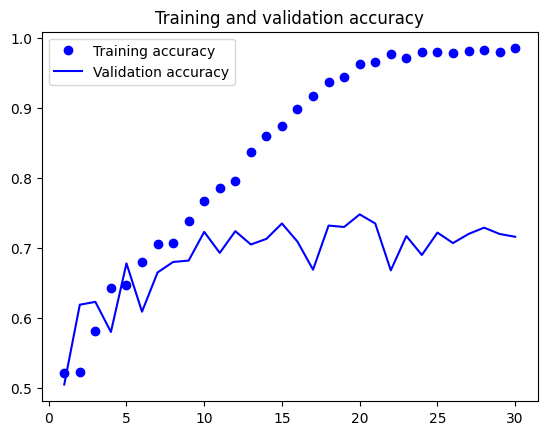

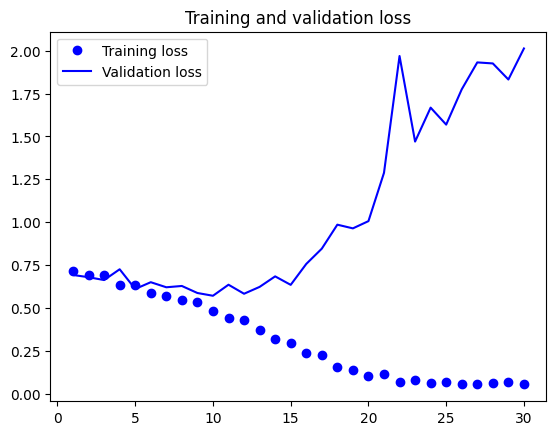

In [9]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 75%.

The validation loss reaches its minimum after only ten epochs and then stalls, whereas the training loss keeps decreasing linearly as training proceeds.

### Evaluating the model on the test set
Let’s check the test accuracy. We’ll reload the model from its saved file to evaluate it as it was before it started overfitting.

In [10]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 417ms/step - accuracy: 0.7085 - loss: 0.5966
Test accuracy: 0.711


Because we have relatively few training samples (2,000), overfitting will be our number one concern. To mitigate it we'll use **data augmentation**.

## Using data augmnentation
Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit.

**Data augmentation** takes the approach of generating more training data from existing training samples by _augmenting_ the samples via a number of random
transformations that yield believable-looking images. The goal is that, at training time, **your model will never see the exact same picture twice**. This helps expose the model to more aspects of the data so it can generalize better.

In Keras, this can be done by adding a number of data augmentation layers at the start of your model.

### Define a data augmentation stage to add to an image model
The following Sequential model chains several random image transformations. In our model, we’d include it right before the Rescaling layer.

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),  # Applies horizontal flipping to a random 50% of the images that go through it
        layers.RandomRotation(0.1),  # Rotates the input images by a random value in the range [-10%, +10%] (fractions of a full circle)
        layers.RandomZoom(0.2)  # Zooms in or out of the image by a random factor in the range [-20%, +20%]
    ]
)

These are just a few of the layers available (for more, see the Keras documentation).

### Displaying some randomly augmented training images

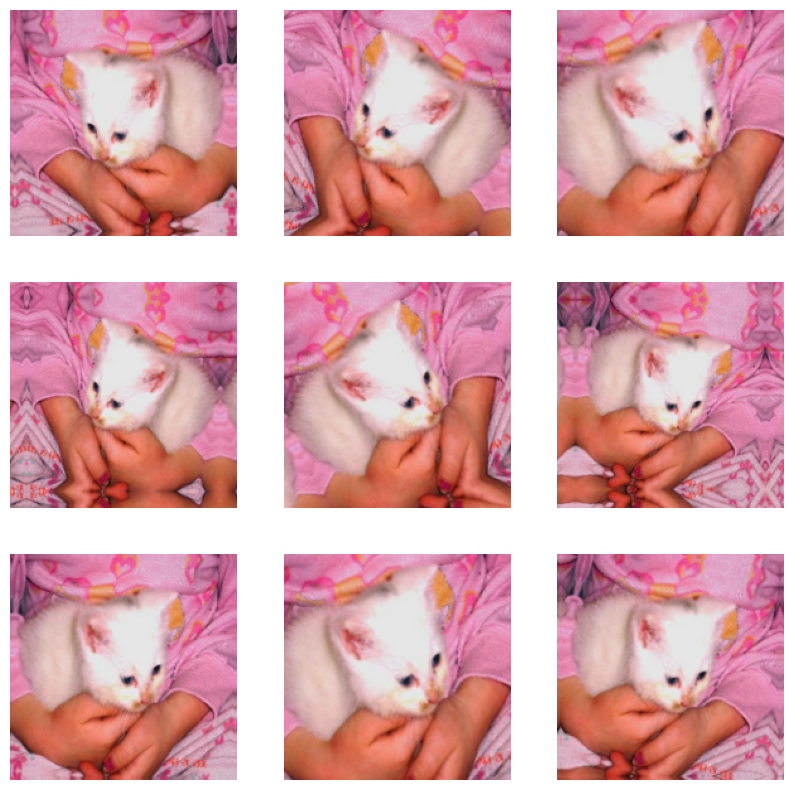

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Defining a new convnet that include image augmentation and dropout
If we train a new model using this data-augmentation configuration, the model will never see the same input twice. But the inputs it sees are still **heavily intercorrelated** because they come from a small number of original images $—$we can’t produce new information; we can only remix existing information. As such, this may not be enough to completely get rid of overfitting.

To further fight overfitting, we’ll also add a ```Dropout``` layer to our model right before the densely connected classifier.

One last thing you should know about random image augmentation layers: just like Dropout, **they’re inactive during inference** (when we call ```predict()``` or ```evaluate()```). During evaluation, our model will behave just the same as when it did not include data augmentation and dropout.

In [13]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [14]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

### Training the regularized convnet

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4969 - loss: 0.7603 - val_accuracy: 0.6010 - val_loss: 0.6928
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5337 - loss: 0.6943 - val_accuracy: 0.5240 - val_loss: 0.6919
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5386 - loss: 0.6915 - val_accuracy: 0.5010 - val_loss: 0.6876
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5656 - loss: 0.6853 - val_accuracy: 0.6060 - val_loss: 0.6727
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6152 - loss: 0.6712 - val_accuracy: 0.6730 - val_loss: 0.6277
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6213 - loss: 0.6541 - val_accuracy: 0.6570 - val_loss: 0.6467
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6331 - loss: 0.6411 - val_accuracy: 0.6630 - val_loss: 0.6080
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6680 - loss: 0.6113 - val_accuracy: 0.6680 - v

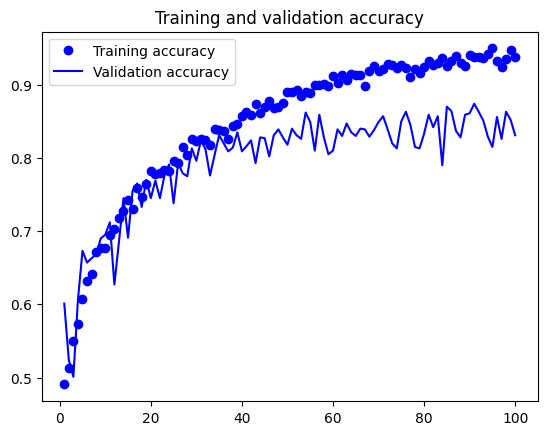

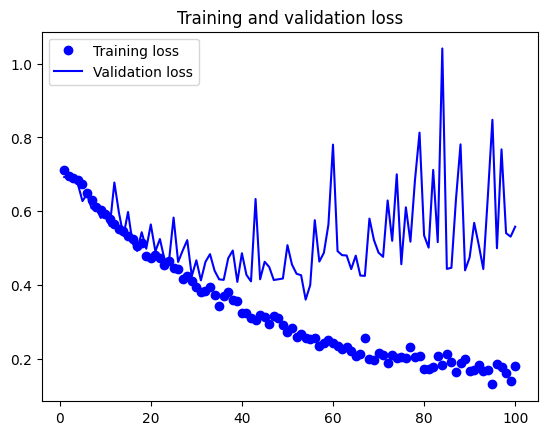

In [16]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Thanks to data augmentation and dropout, we start overfitting much later, around epoch 40. The validation accuracy ends up consistently in the 80–85% range.

### Evaluating the model on the test set

In [17]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 290ms/step - accuracy: 0.8430 - loss: 0.4512
Test accuracy: 0.848


As a result the test accuracy is much higher, ~85% versus the previous 71%.